<h1>Analysis of Senator Stock Trading</h1>

Patrick Cao

<h2>Introduction</h2>

Insider trading, or trading financial assets using information that is not open to the public, is punishable by law in the United States. It is a serious violation -- a maximum penalty of 20 years in prison, and up to $20 million in fines. The Securities and Exchange Commission (SEC) is responsible for identifying and conducting investigations regarding insider trading.

With that being said, U.S. senators (and other congresspeople) often have access to information about upcoming policies or laws before the general public, yet are still allowed to trade stocks. More recently, a few senators have been investigated by the SEC for insider trading using knowledge given to them about the COVID-19 pandemic. 

This tutorial aims to identify potential insider trading, or suspicious trades, by U.S. senators. We will be using data from https://senatestockwatcher.com/, which itself compiles data from https://efdsearch.senate.gov/. Senate stock watcher aggregates financial disclosures from all senators into one nice dataset.

Let's first start by downloading the dataset. While Senate Stock Watcher provides an API for up to date datasets, we can just download a csv file as well. Download the "All Transactions" csv file from https://senatestockwatcher.com/api.html.

Let's load that into a pandas dataframe.

In [231]:
import pandas as pd
import numpy as np
import datetime

df = pd.read_csv('all_transactions.csv')
df.head()

,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link
0,10/13/2020,Joint,--,"XEROX CORP <div class=""text-muted""><em>Rate/Co...",Corporate Bond,Sale (Full),"$1,001 - $15,000",Called bond,Sheldon Whitehouse,https://efdsearch.senate.gov/search/view/ptr/d...
1,10/09/2020,Self,FTV,Fortive Corporation (Exchanged) <br> Vontier C...,Stock,Exchange,"$1,001 - $15,000",--,Sheldon Whitehouse,https://efdsearch.senate.gov/search/view/ptr/d...
2,04/05/2019,Spouse,NVS,Novartis AG,Stock,Sale (Full),"$1,001 - $15,000",--,William Cassidy,https://efdsearch.senate.gov/search/view/ptr/7...
3,10/16/2020,Child,NVDA,NVIDIA Corporation,Stock,Purchase,"$1,001 - $15,000",Underlying asset of Fidelity Brokerage - Depen...,Ron L Wyden,https://efdsearch.senate.gov/search/view/ptr/4...
4,10/16/2020,Child,WDAY,"Workday, Inc.",Stock,Purchase,"$1,001 - $15,000",Underlying asset of Fidelity Brokerage - Depen...,Ron L Wyden,https://efdsearch.senate.gov/search/view/ptr/4...


Let's clean this up a little by limiting this to stocks only, and purchases and sales only.

In [232]:
df = df[df['asset_type'] == 'Stock']

# Turn transaction_date from string into datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Remove (Full) and (Partial) after Sale type
df['type'] = df['type'].apply(lambda x: x.split()[0])

# Limit to only purchases and sales
df = df[(df['type'] == 'Purchase') | (df['type'] == 'Sale')]
df.head()

,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link
2,2019-04-05,Spouse,NVS,Novartis AG,Stock,Sale,"$1,001 - $15,000",--,William Cassidy,https://efdsearch.senate.gov/search/view/ptr/7...
3,2020-10-16,Child,NVDA,NVIDIA Corporation,Stock,Purchase,"$1,001 - $15,000",Underlying asset of Fidelity Brokerage - Depen...,Ron L Wyden,https://efdsearch.senate.gov/search/view/ptr/4...
4,2020-10-16,Child,WDAY,"Workday, Inc.",Stock,Purchase,"$1,001 - $15,000",Underlying asset of Fidelity Brokerage - Depen...,Ron L Wyden,https://efdsearch.senate.gov/search/view/ptr/4...
5,2020-10-16,Child,NVDA,NVIDIA Corporation,Stock,Purchase,"$1,001 - $15,000",Underlying asset of Fidelity Brokerage - Depen...,Ron L Wyden,https://efdsearch.senate.gov/search/view/ptr/4...
6,2020-10-16,Child,WDAY,"Workday, Inc.",Stock,Purchase,"$1,001 - $15,000",Underlying asset of Fidelity Brokerage - Depen...,Ron L Wyden,https://efdsearch.senate.gov/search/view/ptr/4...


We got our senator stock trading data, but now we need actual historical market data to visualize these trades. Let's use yfinance, a python Yahoo! Finance library, to get historical market data on SPY, an ETF tracking the S&P500.

In [233]:
import yfinance as yf

spy = yf.Ticker('SPY')
spy_hist = spy.history(period='max')
spy_hist.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-11-20,357.500000,357.720001,355.250000,355.329987,70417300,0.0,0
2020-11-23,357.279999,358.820007,354.869995,357.459991,63230600,0.0,0
2020-11-24,360.209991,363.809998,359.290009,363.220001,62415900,0.0,0
2020-11-25,363.130005,363.160004,361.480011,362.660004,45330900,0.0,0
2020-11-27,363.839996,364.179993,362.579987,363.670013,28514100,0.0,0


Neat! Now we can start putting these two things together.

<h2>Exploratory Data Analysis</h2>

Let's first aggregate all the senator trading data together, and find the overall trading performance of the senate. We should somehow plot overall senator trading performance against the S&P500.

<h3>Senator Data</h3>

It's a little tough to track performance exactly. The size of each trade isn't an exact number -- it's a range. Let's check out what kinds of values we're working with here.

In [234]:
df['amount'].unique()

array(['$1,001 - $15,000', '$15,001 - $50,000', '$50,001 - $100,000',
       '$100,001 - $250,000', '$5,000,001 - $25,000,000',
       '$1,000,001 - $5,000,000', '$250,001 - $500,000',
       '$500,001 - $1,000,000', 'Over $50,000,000',
       '$25,000,001 - $50,000,000'], dtype=object)

Yikes. The data is not very granular, but the best thing we can probably do is get the lower bound, upper bound, and middle value of each trade.

In [235]:
# Returns a tuple of [lower bound, middle, upper bound] for the given category
def getBounds(amount):
    
    # This amount shows up once in the entire dataset. Let's just assume the trade is $50m for now. It won't affect our analysis too much.
    if amount == 'Over $50,000,000':
        return (5e7, 5e7, 5e7)
    
    split = amount.split(' - ')
    lower = int(split[0][1:].replace(',', ''))
    upper = int(split[1][1:].replace(',', ''))
    mid = lower + ((upper - lower) / 2)

    return [lower, mid, upper]

bounds = pd.Series(df['amount'].apply(getBounds))

df['lower_amt'] = bounds.apply(lambda x: x[0])
df['mid_amt'] = bounds.apply(lambda x: x[1])
df['upper_amt'] = bounds.apply(lambda x: x[2])

df

,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,lower_amt,mid_amt,upper_amt
2,2019-04-05,Spouse,NVS,Novartis AG,Stock,Sale,"$1,001 - $15,000",--,William Cassidy,https://efdsearch.senate.gov/search/view/ptr/7...,1001.0,8000.5,15000.0
3,2020-10-16,Child,NVDA,NVIDIA Corporation,Stock,Purchase,"$1,001 - $15,000",Underlying asset of Fidelity Brokerage - Depen...,Ron L Wyden,https://efdsearch.senate.gov/search/view/ptr/4...,1001.0,8000.5,15000.0
4,2020-10-16,Child,WDAY,"Workday, Inc.",Stock,Purchase,"$1,001 - $15,000",Underlying asset of Fidelity Brokerage - Depen...,Ron L Wyden,https://efdsearch.senate.gov/search/view/ptr/4...,1001.0,8000.5,15000.0
5,2020-10-16,Child,NVDA,NVIDIA Corporation,Stock,Purchase,"$1,001 - $15,000",Underlying asset of Fidelity Brokerage - Depen...,Ron L Wyden,https://efdsearch.senate.gov/search/view/ptr/4...,1001.0,8000.5,15000.0
6,2020-10-16,Child,WDAY,"Workday, Inc.",Stock,Purchase,"$1,001 - $15,000",Underlying asset of Fidelity Brokerage - Depen...,Ron L Wyden,https://efdsearch.senate.gov/search/view/ptr/4...,1001.0,8000.5,15000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8685,2014-12-11,Spouse,DVFAX,Cohen &amp; Steers Dividend Value A (NASDAQ),Stock,Purchase,"$1,001 - $15,000",--,Susan M Collins,https://efdsearch.senate.gov/search/view/ptr/d...,1001.0,8000.5,15000.0
8690,2014-12-12,Spouse,XOM,Exxon Mobil Corporation (NYSE),Stock,Sale,"$1,001 - $15,000",Sep,Pat Roberts,https://efdsearch.senate.gov/search/view/ptr/f...,1001.0,8000.5,15000.0
8691,2014-12-19,Spouse,BA,The Boeing Company (NYSE),Stock,Purchase,"$1,001 - $15,000",R,Pat Roberts,https://efdsearch.senate.gov/search/view/ptr/f...,1001.0,8000.5,15000.0
8692,2014-12-12,Spouse,BAC,Bank of America Corporation (NYSE),Stock,Sale,"$1,001 - $15,000",R,Pat Roberts,https://efdsearch.senate.gov/search/view/ptr/f...,1001.0,8000.5,15000.0


Alright, now we got some rough numerical bounds of each transaction, we can group trades together by date and find the aggregate for each day.

In [236]:
aggregate_action = df.groupby([pd.Grouper(key='transaction_date', freq='W'), 'type']).sum()

# Groupby makes transaction_date and type an index, we want to convert those back into a column
aggregate_action.reset_index(inplace=True)

aggregate_buys = aggregate_action[aggregate_action['type'] == 'Purchase']
aggregate_sells = aggregate_action[aggregate_action['type'] == 'Sale']
aggregate_sells['mid_amt'] = aggregate_sells['mid_amt'] * -1

print(aggregate_buys.head())
print(aggregate_sells.head())

  transaction_date      type  lower_amt  mid_amt  upper_amt
0       2012-09-16  Purchase     1001.0   8000.5    15000.0
1       2012-12-23  Purchase     1001.0   8000.5    15000.0
2       2013-03-17  Purchase     1001.0   8000.5    15000.0
3       2013-06-16  Purchase     1001.0   8000.5    15000.0
4       2013-09-15  Purchase     1001.0   8000.5    15000.0
   transaction_date  type  lower_amt  mid_amt  upper_amt
6        2014-01-12  Sale     2002.0 -16001.0    30000.0
7        2014-01-19  Sale     2002.0 -16001.0    30000.0
10       2014-03-16  Sale     2002.0 -16001.0    30000.0
11       2014-04-13  Sale     1001.0  -8000.5    15000.0
12       2014-05-04  Sale     2002.0 -16001.0    30000.0


We are now ready to plot senator trades against the market.

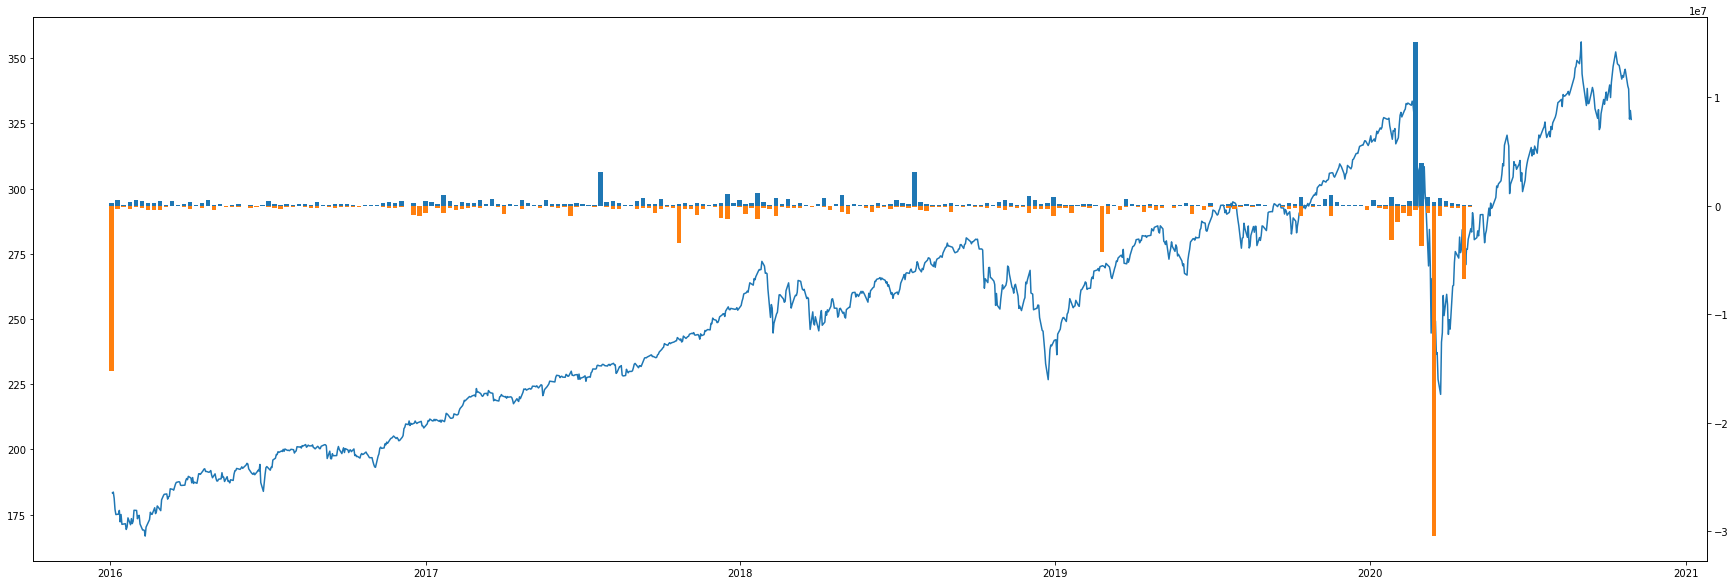

In [239]:
import matplotlib.pyplot as plt

start_date = '2010-01-01'
end_date = '2020-11-01'

aggregate_buys = aggregate_buys[(aggregate_buys['transaction_date'] > start_date) & (aggregate_buys['transaction_date'] < end_date)]
aggregate_sells = aggregate_sells[(aggregate_sells['transaction_date'] > start_date) & (aggregate_sells['transaction_date'] < end_date)]

# We have a lot of data, so we should make the figure very large
plt.figure(figsize=(30,10))

spy_hist.reset_index(inplace=True)
market = spy_hist[(spy_hist['Date'] > start_date) & (spy_hist['Date'] < end_date)]
plt.plot(market['Date'], market['Close'])

plt.twinx()

plt.bar(aggregate_buys['transaction_date'], aggregate_buys['mid_amt'], width=5)
plt.bar(aggregate_sells['transaction_date'], aggregate_sells['mid_amt'], width=5)


plt.show()

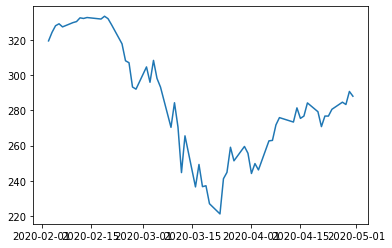